# Burgers Optimization with a Gradient from Differentiable Physics

manual!

like PINN... now only DOFs are initial state! rest is determined by simulation

build graph from sim (ignore warning)

In [1]:
from phi.tf.flow import *

# run with phiflow
n = 128
dt = 1./32.
initial = np.zeros([n,1]) # start from 0

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state0 = BurgersVelocity(domain, velocity=initial, viscosity=0.01/np.pi)

# start with a state0, to be modified
state_in = state0.copied_with(velocity=placeholder)
states = [state_in]

for i in range(32):
    states.append( Burgers().step(states[-1],dt=dt) )

print("Each velocity is a phiflow grid like this one: " + format(states[-1].velocity) )

Could not load resample cuda libraries: CUDA binaries not found at /Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them




Instructions for updating:
Use `tf.cast` instead.





/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


Each velocity is a phiflow grid like this one: Grid[128(1), size=[2.], <class 'numpy.float32'>]


Note, this didnt run anything! let's set up the loss

In [2]:
sess = Session(None) 

# enforce constraints at time t=0.5 (step 16)
solution_t16 = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] )
target = state0.copied_with(velocity=np.reshape(solution_t16,[n,1]))

loss = math.sum( (states[16].velocity.data - target.velocity.data)**2 ) / n
sess.initialize_variables()

# compute initial loss
s,l = sess.run([states[-1],loss], feed_dict={state_in: state0})
print("Initial loss "+format(l))






Initial loss 0.3829152584075928


Note: because we're only constraining timestep 16, we could actually omit steps 17 to 31 here, but for fairness and comparison with the PINN case, let's include them.

In [3]:
LR = 5.
stateN = state0
grads = []
for i in range(5):
    grads.append( tf.gradients(loss, [state_in.velocity.data] ) ) # use TF
    grads.append( gradients(loss, state_in.velocity) ) # phiflow wrapper also works

    state_updated = state_in.copied_with( velocity=(state_in.velocity - LR*grads[-1]) )
    stateN,l = sess.run([state_updated,loss], feed_dict={state_in: stateN})

    #s,l = sess.run([states[-1],loss], feed_dict={state_in: stateN})
    print( "Step {}, loss = {}".format(i,l) )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step 0, loss = 0.3829152584075928
Step 1, loss = 0.3334265947341919
Step 2, loss = 0.2905231714248657
Step 3, loss = 0.25346457958221436
Step 4, loss = 0.2215319573879242


Let's visualize the reconstruction: first 

gradient, pointing in the "wrong" direction, we're taking a step along the negative direction

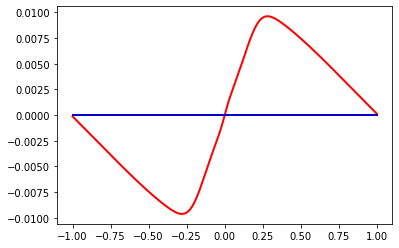

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# first gradient
[grad0,s0] = sess.run([grads[0],state0], feed_dict={state_in: stateN}) #.velocity.data
fig.plot(pltx, grad0[0].flatten()             , lw=2, color='red')  

# # target constraint at t=0.5
# fig.plot(pltx, target.velocity.data.flatten(), lw=2, color='forestgreen') 

# # constrained state of simulation
# contrained_state = sess.run(states[16], feed_dict={state_in: stateN}).velocity.data
fig.plot(pltx, state0.velocity.data.flatten(), lw=2, color='mediumblue')

... how well the last state of the simulation matches the target

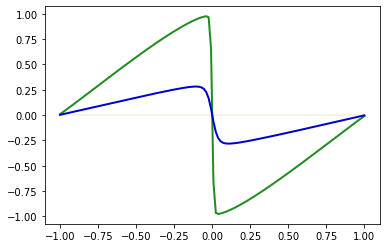

In [5]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# initial guess for optimization, this is where we started out...
fig.plot(pltx, initial.flatten()             , lw=2, color='linen')  

# target constraint at t=0.5
fig.plot(pltx, target.velocity.data.flatten(), lw=2, color='forestgreen') 

# constrained state of simulation
contrained_state = sess.run(states[16], feed_dict={state_in: stateN}).velocity.data
fig.plot(pltx, contrained_state.flatten(), lw=2, color='mediumblue')

Seems to be going in the right direction, but not there yet... It's a bit slow, and needs more iterations.

Suboptimal so far: update via gradient manually computed with multiple TF session run() calls. TF optimizers do this internally, more flexibly and more efficiently... Let's start over, and switch to a `tf.train.Optimizer()` instead.